In [38]:
import pathlib

import pandas as pd
import polars as pl
from hydra import compose, initialize, utils
import seaborn as sns
from omegaconf import OmegaConf
from plotly import express as pex
import plotly.io as pio
from flatten_dict import flatten

In [39]:
sns.set_style("dark")

In [40]:
pio.templates.default = "plotly_dark"

# ALS hyperparams

In [41]:
with initialize(config_path="configs", version_base="1.3"):
    config = compose("als_optim", return_hydra_config=True)

In [42]:
exp_dir = pathlib.Path(config.hydra.sweep.dir)

In [43]:
files = list(exp_dir.rglob("cv_res.csv"))

In [44]:
rows = []

for file in files:
    map_value = pl.scan_csv(file).filter(pl.col("name") == "MAP").collect().get_column("value").mean()
    params_path = file.parent / ".hydra" / "overrides.yaml"
    config = OmegaConf.load(params_path)
    config = flatten(OmegaConf.from_dotlist(OmegaConf.to_container(config)), reducer="dot")
    config["mean_MAP"] = map_value
    rows.append(config)

In [45]:
als_hyperparams = pd.DataFrame.from_dict(rows)

In [46]:
pex.parallel_coordinates(als_hyperparams, dimensions=als_hyperparams.columns, title="ALS hyperparams visualization")

# Сравнение с другими алгоритмами

In [47]:
with initialize(config_path="configs", version_base="1.3"):
    config = compose("cross_val", return_hydra_config=True)

In [48]:
exp_dir = pathlib.Path(config.hydra.sweep.dir)

In [49]:
files = list(exp_dir.rglob("cv_res.csv"))

In [50]:
dataframes = []

for file in files:
    dataframes.append(pl.read_csv(file))

In [51]:
cv_res = pl.concat(dataframes)
del dataframes

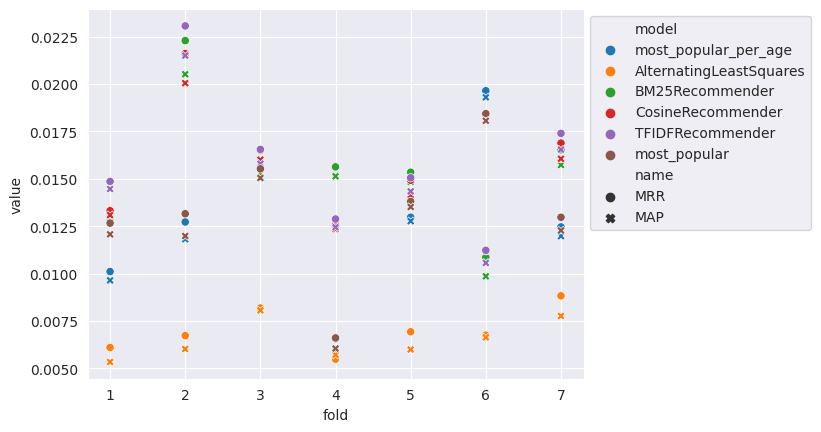

In [52]:
ax = sns.scatterplot(cv_res.filter(pl.col("name").is_in(["MRR", "MAP"])), x="fold", y="value", hue="model", style="name")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.grid(True)